<a href="https://colab.research.google.com/github/rithikkulkarni/Video-Virality/blob/main/notebooks/regression_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 YouTube Video Virality – Regression Modeling
This notebook trains regression models to predict:
- `viewCount`
- `likeCount`
- `commentCount`

using pre-extracted video features (image, text, and ResNet embeddings).


In [1]:
!pip install xgboost

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/rithikkulkarni/Video-Virality/refs/heads/main/data/video_details_v5.csv"
df = pd.read_csv(url)
df.head()

,video_id,avg_red,avg_green,avg_blue,brightness,contrast,thumbnail_text,text_word_count,text_sentiment,title,...,resnet_2039,resnet_2040,resnet_2041,resnet_2042,resnet_2043,resnet_2044,resnet_2045,resnet_2046,resnet_2047,viral
0,rR5udw_g8MY,140.592743,131.640642,117.352292,129.861892,71.016322,NaN,0,0.0,I Tried to Blind Speedrun all of Mario Kart World,...,0.664808,0.042745,0.008452,1.696102,0.878194,0.444913,0.082426,1.004559,0.362394,0
1,5z9C_5yl0es,165.267865,136.143646,78.115677,126.509062,85.693186,NaN,0,0.0,Nintendo Switch 2 Welcome Tour is Sad and Awful,...,0.566910,0.910501,0.000000,1.924997,0.134057,0.083707,0.363867,0.266076,0.201331,0
2,mve1fSGfwRQ,141.777899,151.830069,137.094392,143.567454,75.687950,NaN,0,0.0,I Became The Drift King of Mario Kart World,...,0.048810,0.488042,0.190300,0.161197,0.718608,0.556553,0.399344,0.657456,0.888009,0
3,QLeTqvcx6uY,104.694306,123.529010,71.574913,99.932743,82.475221,PD!\n7 ONS\ntae Your/Daddy\n\nsaa rat Aina air...,12,0.0,"I Watched E3 2005, Twenty Years Later. It's no...",...,0.006484,0.637998,0.398325,0.016811,0.250087,0.553193,1.987138,1.022643,0.242517,0
4,hENv3EUe6f0,138.603299,173.867396,143.154340,151.875012,76.828971,y ip a»,3,0.0,I must Carry The Glass with CallMeKevin,...,0.040986,0.040346,0.000000,0.369061,0.414916,0.593644,0.537817,1.485391,0.748773,0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Drop non-numeric or identifier columns
drop_cols = [
    "video_id", "thumbnail_text", "title", "channel_id",
    "viewCount", "likeCount", "commentCount", "viral"
]

# Drop ResNet columns
resnet_cols = [col for col in df.columns if col.startswith("resnet_")]
drop_cols = [
    "video_id", "thumbnail_text", "title", "channel_id",
    "viewCount", "likeCount", "commentCount", "viral"
] + resnet_cols

X = df.drop(columns=drop_cols)
y_view = df["viewCount"]
y_like = df["likeCount"]
y_comment = df["commentCount"]

# Optional: log-transform to normalize skewed counts
y_view_log = np.log1p(y_view)
y_like_log = np.log1p(y_like)
y_comment_log = np.log1p(y_comment)

# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, yv_train, yv_test = train_test_split(X_scaled, y_view_log, test_size=0.2, random_state=42)
_, _, yl_train, yl_test = train_test_split(X_scaled, y_like_log, test_size=0.2, random_state=42)
_, _, yc_train, yc_test = train_test_split(X_scaled, y_comment_log, test_size=0.2, random_state=42)

In [11]:
# Defining our regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [12]:
# Defining our evaluation function
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, target_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"📈 {type(model).__name__} on {target_name}")
    print("R^2:", round(r2_score(y_test, preds), 4))
    print("MAE:", round(mean_absolute_error(y_test, preds), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test, preds)), 2))

    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, preds, alpha=0.3)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{type(model).__name__} - {target_name}")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()

In [13]:
# Feature Importance Function
import seaborn as sns

def plot_feature_importance(model, feature_names, title, top_n=15, exclude_prefix="resnet_"):
    # Handle model-specific importance attributes
    if hasattr(model, "coef_"):
        importance = model.coef_.flatten() if model.coef_.ndim > 1 else model.coef_
    elif hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        print(f"No feature importance attribute for {type(model).__name__}")
        return

    # Create DataFrame for plotting
    feat_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    })

    # Filter out resnet embeddings
    feat_df = feat_df[~feat_df["feature"].str.startswith(exclude_prefix)]

    # Sort by absolute importance
    feat_df["abs_importance"] = feat_df["importance"].abs()
    feat_df = feat_df.sort_values(by="abs_importance", ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")
    plt.title(f"Top {top_n} Non-ResNet Features - {title}")
    plt.tight_layout()
    plt.show()


🔹 Linear Regression - Predicting viewCount
📈 LinearRegression on viewCount
R^2: 0.1236
MAE: 0.91
RMSE: 1.18


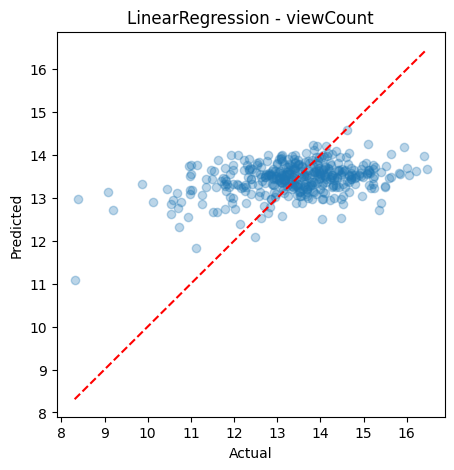

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


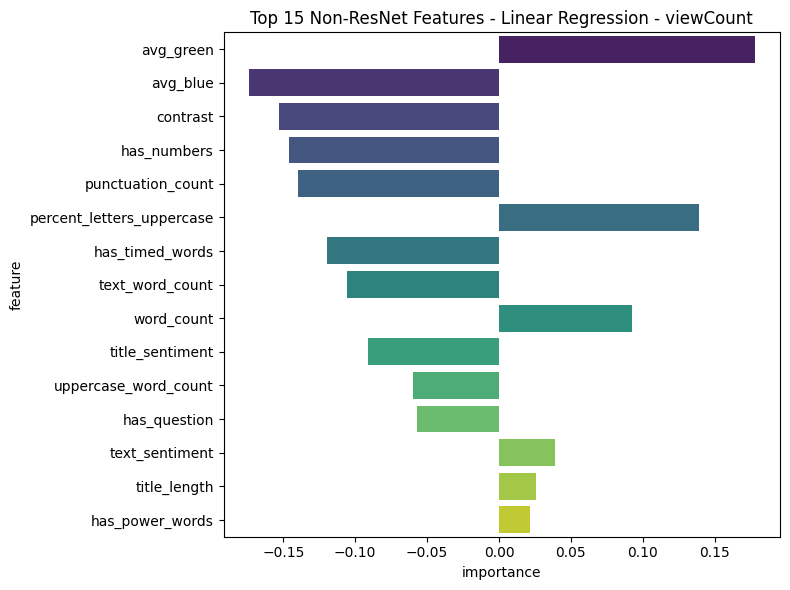


🔹 Linear Regression - Predicting likeCount
📈 LinearRegression on likeCount
R^2: 0.1561
MAE: 0.8
RMSE: 1.08


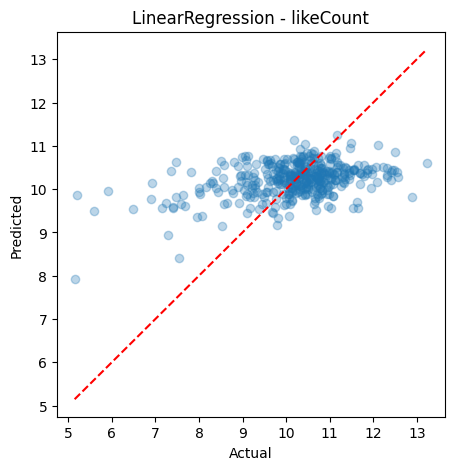

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


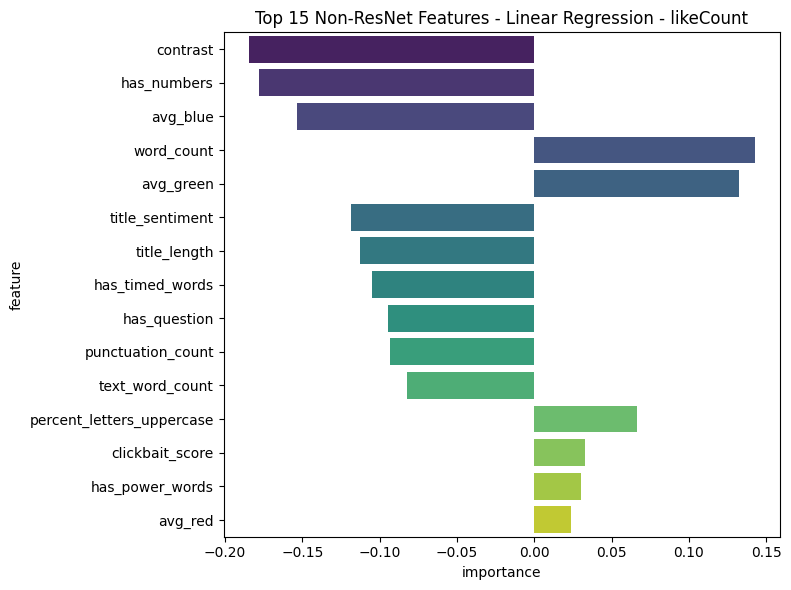


🔹 Linear Regression - Predicting commentCount
📈 LinearRegression on commentCount
R^2: 0.0849
MAE: 0.94
RMSE: 1.24


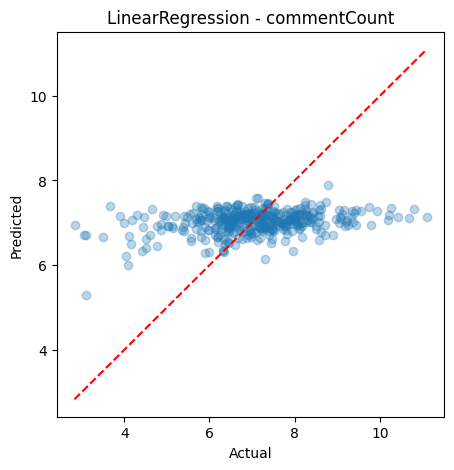

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


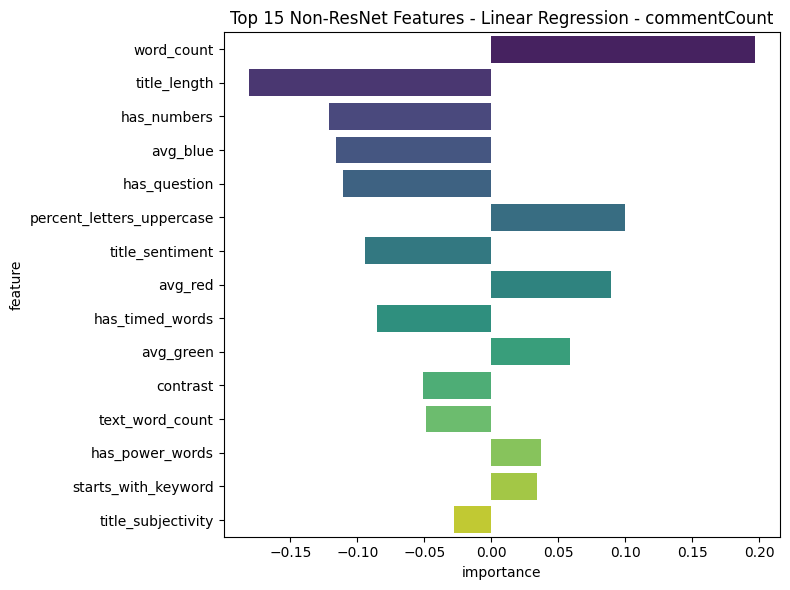


🔹 Ridge Regression - Predicting viewCount
📈 Ridge on viewCount
R^2: 0.1237
MAE: 0.91
RMSE: 1.18


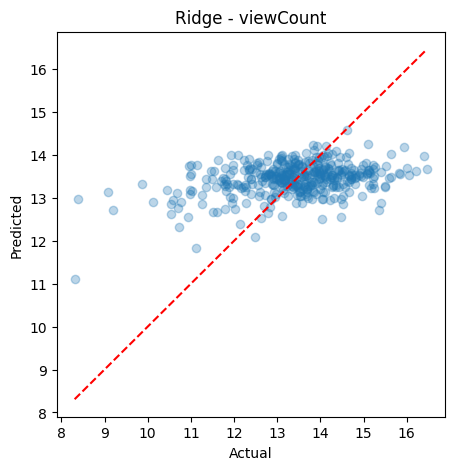

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


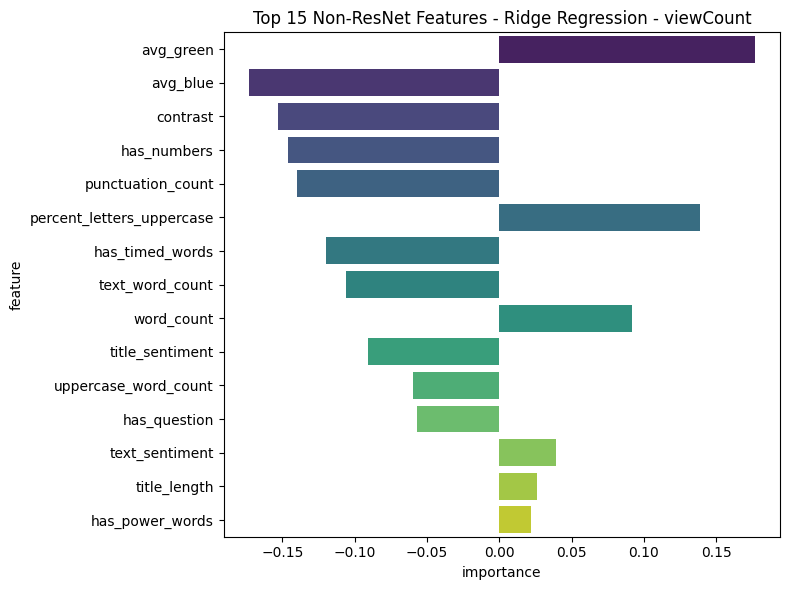


🔹 Ridge Regression - Predicting likeCount
📈 Ridge on likeCount
R^2: 0.1562
MAE: 0.8
RMSE: 1.08


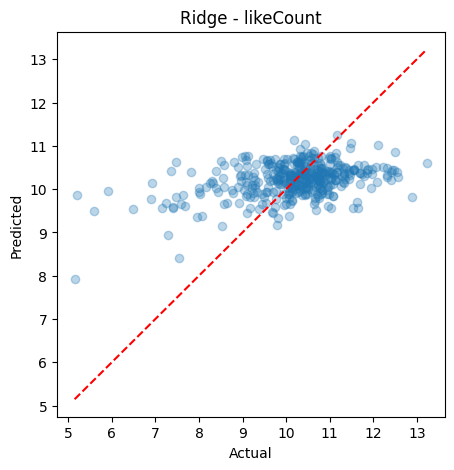

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


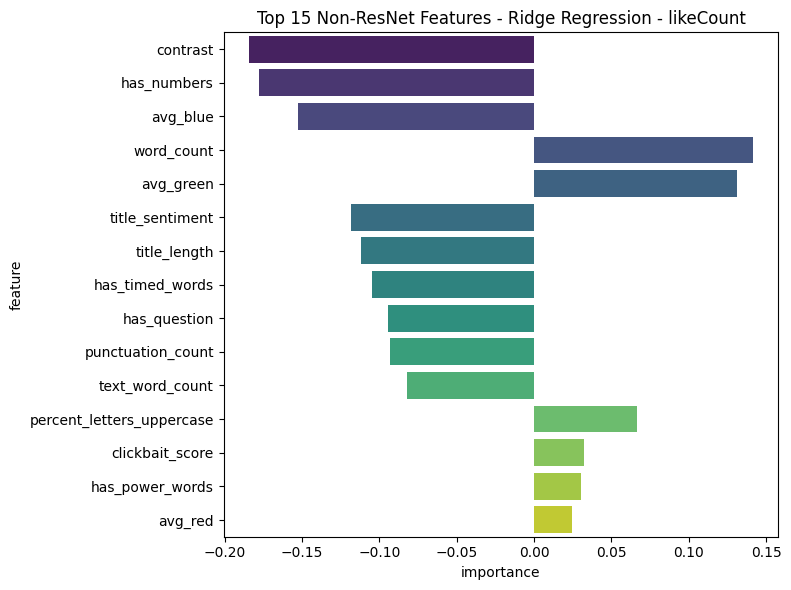


🔹 Ridge Regression - Predicting commentCount
📈 Ridge on commentCount
R^2: 0.085
MAE: 0.94
RMSE: 1.24


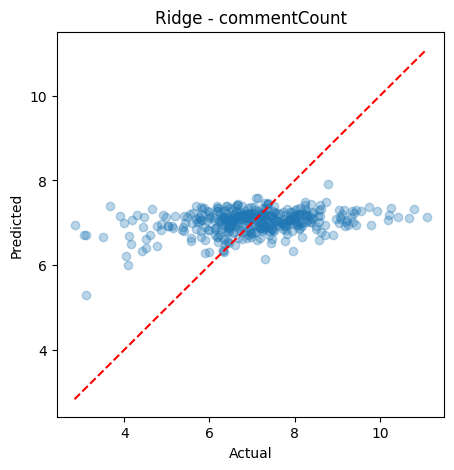

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


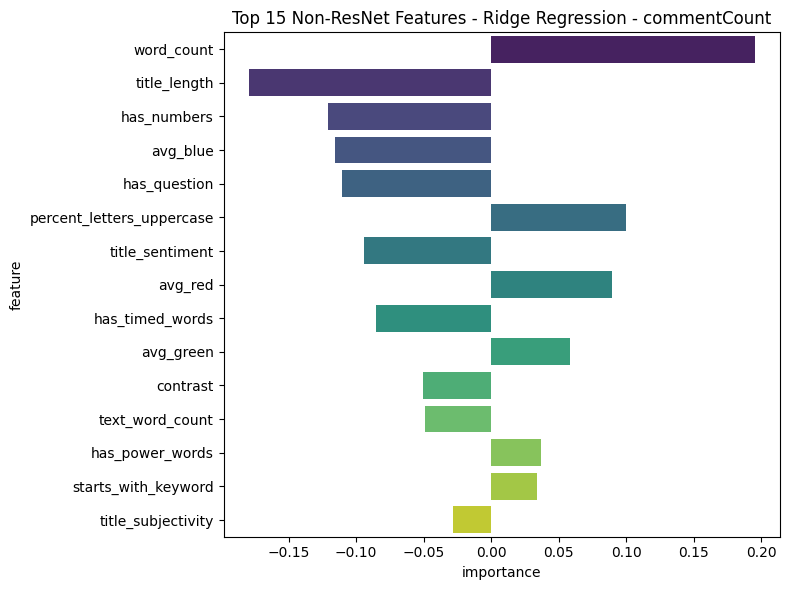


🔹 Random Forest - Predicting viewCount
📈 RandomForestRegressor on viewCount
R^2: 0.1807
MAE: 0.86
RMSE: 1.14


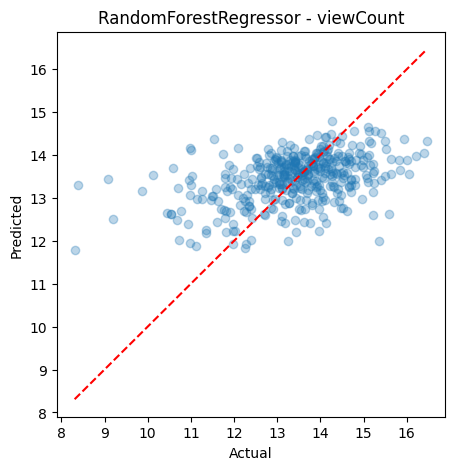

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


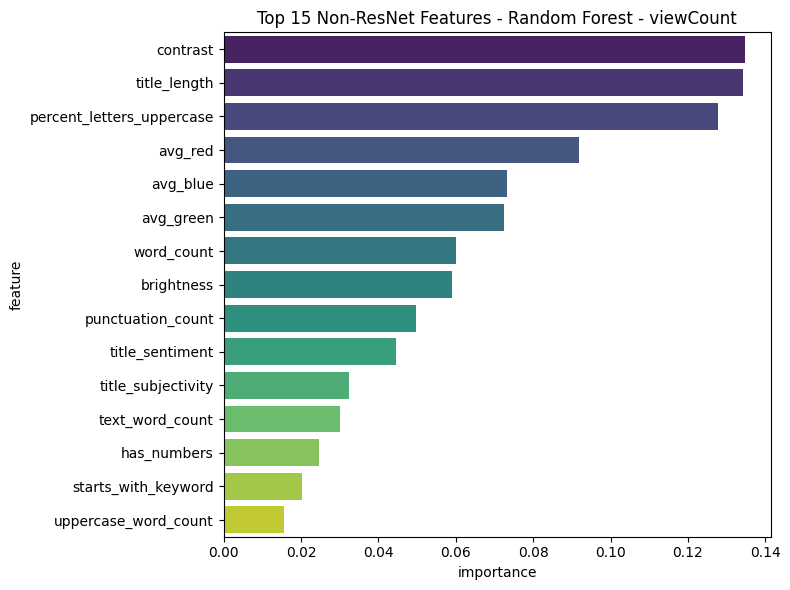


🔹 Random Forest - Predicting likeCount
📈 RandomForestRegressor on likeCount
R^2: 0.1399
MAE: 0.78
RMSE: 1.09


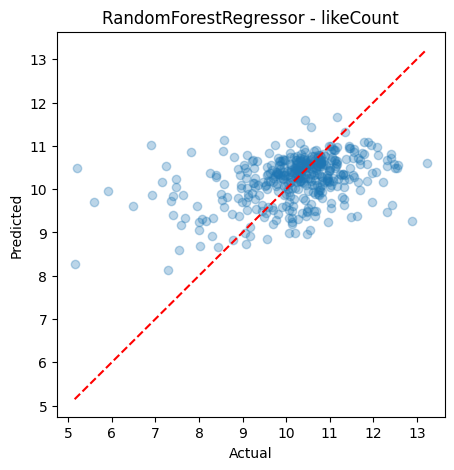

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


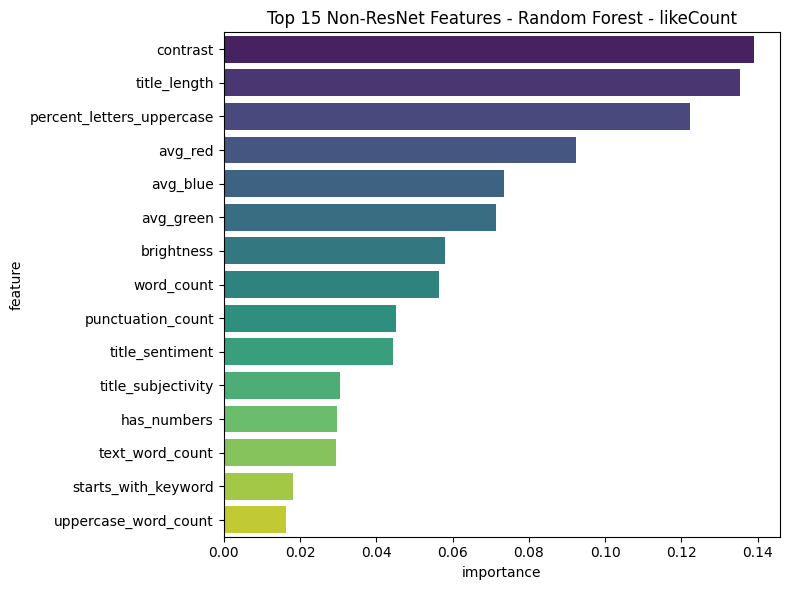


🔹 Random Forest - Predicting commentCount
📈 RandomForestRegressor on commentCount
R^2: 0.1215
MAE: 0.9
RMSE: 1.21


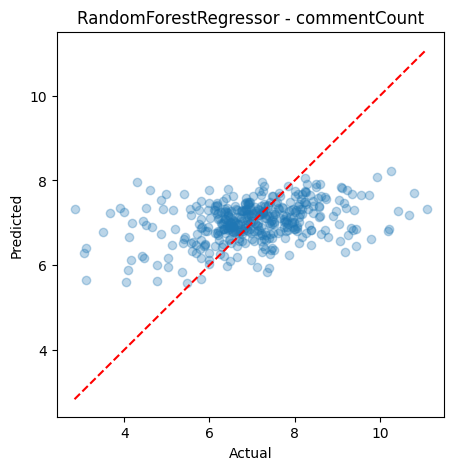

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


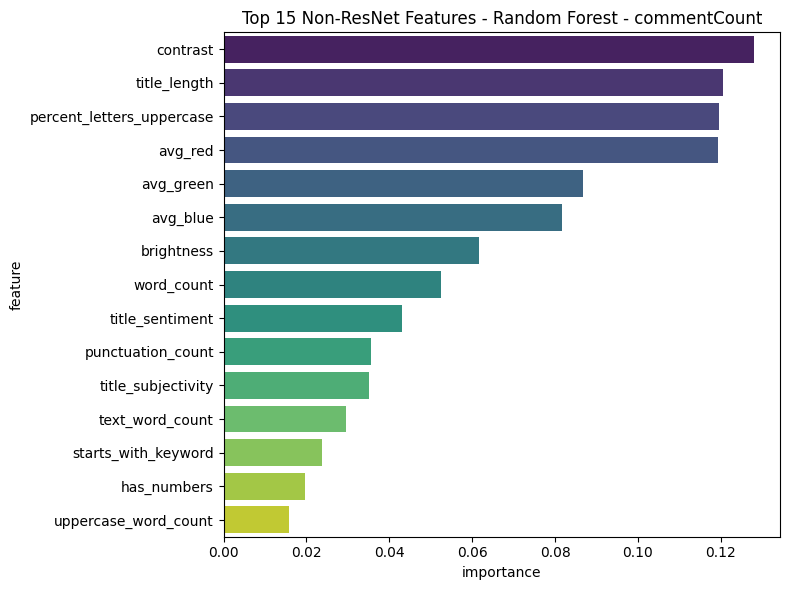


🔹 XGBoost - Predicting viewCount
📈 XGBRegressor on viewCount
R^2: 0.1232
MAE: 0.88
RMSE: 1.18


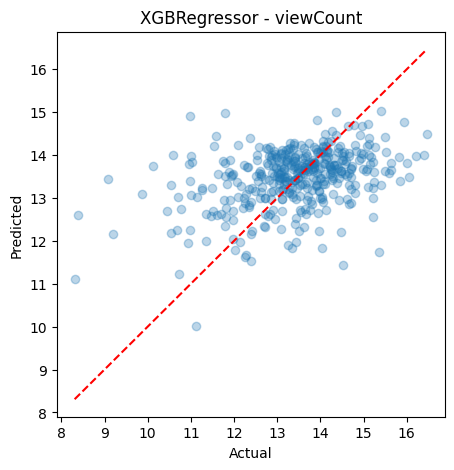

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


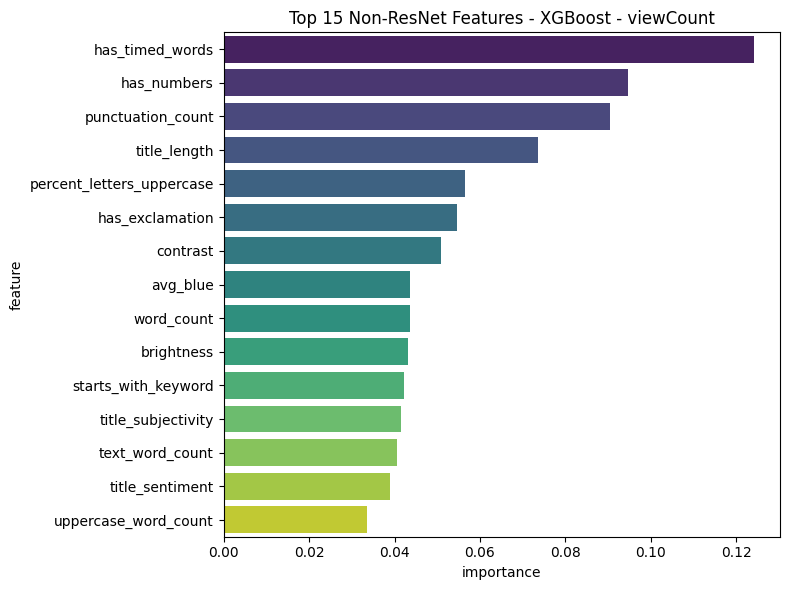


🔹 XGBoost - Predicting likeCount
📈 XGBRegressor on likeCount
R^2: 0.1145
MAE: 0.79
RMSE: 1.1


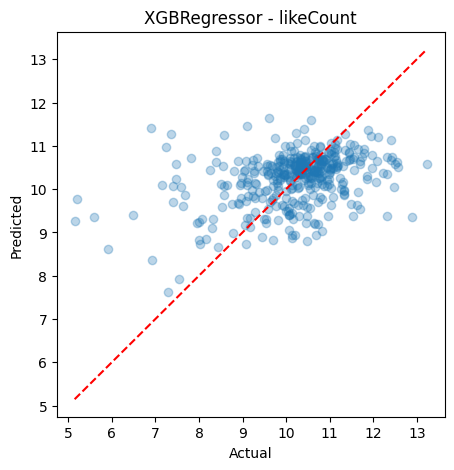

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


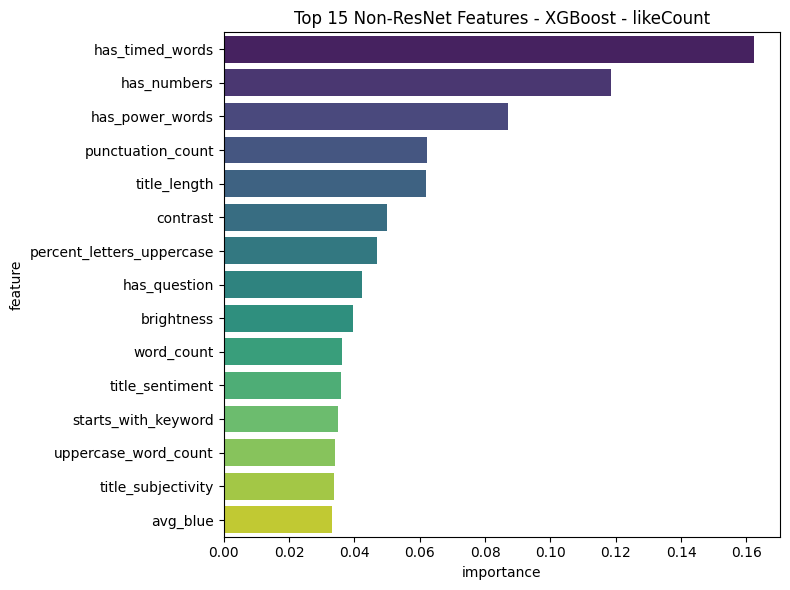


🔹 XGBoost - Predicting commentCount
📈 XGBRegressor on commentCount
R^2: 0.1433
MAE: 0.88
RMSE: 1.2


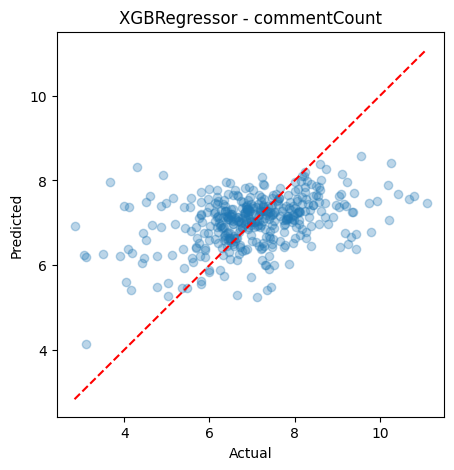

<ipython-input-13-588076733>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_df, palette="viridis")


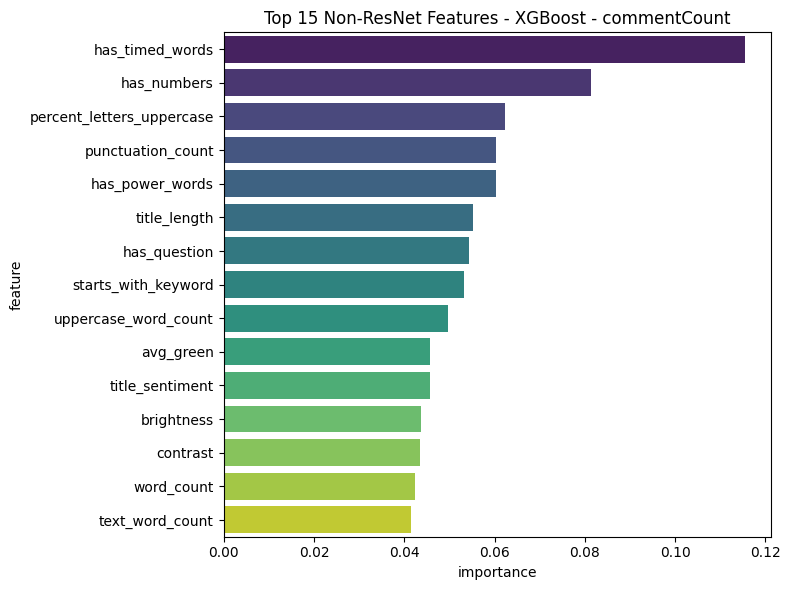

In [14]:
# Training & Evaluating for all our target variables

# for plotting
feature_names = X.columns.tolist()

for name, model in models.items():
    print(f"\n🔹 {name} - Predicting viewCount")
    evaluate_model(model, X_train, yv_train, X_test, yv_test, "viewCount")
    plot_feature_importance(model, feature_names, f"{name} - viewCount")

    print(f"\n🔹 {name} - Predicting likeCount")
    evaluate_model(model, X_train, yl_train, X_test, yl_test, "likeCount")
    plot_feature_importance(model, feature_names, f"{name} - likeCount")

    print(f"\n🔹 {name} - Predicting commentCount")
    evaluate_model(model, X_train, yc_train, X_test, yc_test, "commentCount")
    plot_feature_importance(model, feature_names, f"{name} - commentCount")
